In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf
from sklearn.metrics import mean_squared_error

In [2]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/tmp/ipykernel_10927/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [3]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [4]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Data preprocessing

#### Checking any problems with the data

In [5]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [6]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    df = one_hot_encode(df, 'StateHoliday')
    df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [8]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
0,1115,2,2013-01-01,0,0,0,0,1,0,1,0,0
1,1114,2,2013-01-01,0,0,0,0,1,0,1,0,0
2,1113,2,2013-01-01,0,0,0,0,1,0,1,0,0
3,1112,2,2013-01-01,0,0,0,0,1,0,1,0,0
4,1111,2,2013-01-01,0,0,0,0,1,0,1,0,0


In [9]:
test_df = preprocess_data(test_df)
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a
0,41088,1115,6,2015-08-01,1.0,0,1,1,0
1,41087,1114,6,2015-08-01,1.0,0,0,1,0
2,41086,1113,6,2015-08-01,1.0,0,0,1,0
3,41085,1112,6,2015-08-01,1.0,0,0,1,0
4,41084,1111,6,2015-08-01,1.0,0,0,1,0


## Exploring the data

In [10]:
corr_df = train_df[list(train_df.columns[1:])].corr()
corr_df

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
DayOfWeek,1.000000,0.000183,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.052889,-0.040981,-0.040668,-0.001345
Date,0.000183,1.000000,0.041904,0.012679,-0.000157,0.017249,0.001068,-0.003736,-0.001144,-0.000957,0.013887
Sales,-0.462125,0.041904,1.000000,0.894711,0.678472,0.452345,0.085124,0.254216,-0.203028,-0.117497,-0.092618
Customers,-0.386445,0.012679,0.894711,1.000000,0.616768,0.316169,0.071568,0.226608,-0.180900,-0.104522,-0.083007
Open,-0.528963,-0.000157,0.678472,0.616768,1.000000,0.295042,0.086171,0.378378,-0.302107,-0.175158,-0.137685
Promo,-0.392925,0.017249,0.452345,0.316169,0.295042,1.000000,0.067483,0.012353,-0.004034,0.019847,-0.049964
SchoolHoliday,-0.205388,0.001068,0.085124,0.071568,0.086171,0.067483,1.000000,-0.148651,0.029126,0.159098,0.136405
StateHoliday__0,0.052889,-0.003736,0.254216,0.226608,0.378378,0.012353,-0.148651,1.000000,-0.803389,-0.458547,-0.358514
StateHoliday__a,-0.040981,-0.001144,-0.203028,-0.180900,-0.302107,-0.004034,0.029126,-0.803389,1.000000,-0.011599,-0.009069
StateHoliday__b,-0.040668,-0.000957,-0.117497,-0.104522,-0.175158,0.019847,0.159098,-0.458547,-0.011599,1.000000,-0.005176


In [11]:
fig = px.imshow(corr_df)
fig.show()

Customers and Open columns are strongly correlated with Sales

#### Looking at the data of a random store

In [12]:
df_store_x = train_df[train_df['Store'] == 1011]
df_store_x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
104,1011,2,2013-01-01,0,0,0,0,1,0,1,0,0
1218,1011,3,2013-01-02,7049,900,1,0,1,1,0,0,0
2333,1011,4,2013-01-03,6377,802,1,0,1,1,0,0,0
3448,1011,5,2013-01-04,5981,793,1,0,1,1,0,0,0
4563,1011,6,2013-01-05,7963,1043,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1011738,1011,1,2015-07-27,10066,902,1,1,1,1,0,0,0
1012853,1011,2,2015-07-28,8673,834,1,1,1,1,0,0,0
1013968,1011,3,2015-07-29,7755,732,1,1,1,1,0,0,0
1015083,1011,4,2015-07-30,9227,877,1,1,1,1,0,0,0


In [13]:
store_corr_df = train_df[list(df_store_x.columns[1:])].corr()
store_corr_df

,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
DayOfWeek,1.000000,0.000183,-0.462125,-0.386445,-0.528963,-0.392925,-0.205388,0.052889,-0.040981,-0.040668,-0.001345
Date,0.000183,1.000000,0.041904,0.012679,-0.000157,0.017249,0.001068,-0.003736,-0.001144,-0.000957,0.013887
Sales,-0.462125,0.041904,1.000000,0.894711,0.678472,0.452345,0.085124,0.254216,-0.203028,-0.117497,-0.092618
Customers,-0.386445,0.012679,0.894711,1.000000,0.616768,0.316169,0.071568,0.226608,-0.180900,-0.104522,-0.083007
Open,-0.528963,-0.000157,0.678472,0.616768,1.000000,0.295042,0.086171,0.378378,-0.302107,-0.175158,-0.137685
Promo,-0.392925,0.017249,0.452345,0.316169,0.295042,1.000000,0.067483,0.012353,-0.004034,0.019847,-0.049964
SchoolHoliday,-0.205388,0.001068,0.085124,0.071568,0.086171,0.067483,1.000000,-0.148651,0.029126,0.159098,0.136405
StateHoliday__0,0.052889,-0.003736,0.254216,0.226608,0.378378,0.012353,-0.148651,1.000000,-0.803389,-0.458547,-0.358514
StateHoliday__a,-0.040981,-0.001144,-0.203028,-0.180900,-0.302107,-0.004034,0.029126,-0.803389,1.000000,-0.011599,-0.009069
StateHoliday__b,-0.040668,-0.000957,-0.117497,-0.104522,-0.175158,0.019847,0.159098,-0.458547,-0.011599,1.000000,-0.005176


In [14]:
fig = px.imshow(store_corr_df)
fig.show()

Same correlation is observed for this particular store

### Trend plot

In [15]:
fig = px.line(df_store_x, x="Date", y="Sales")
fig.show()

#### Exploring seasonal decomposition using moving averages.

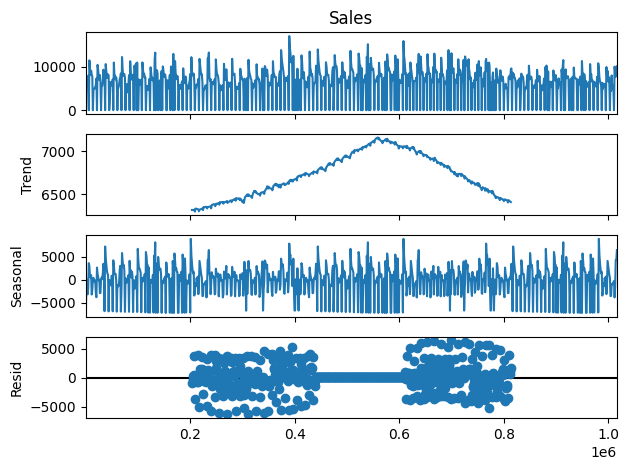

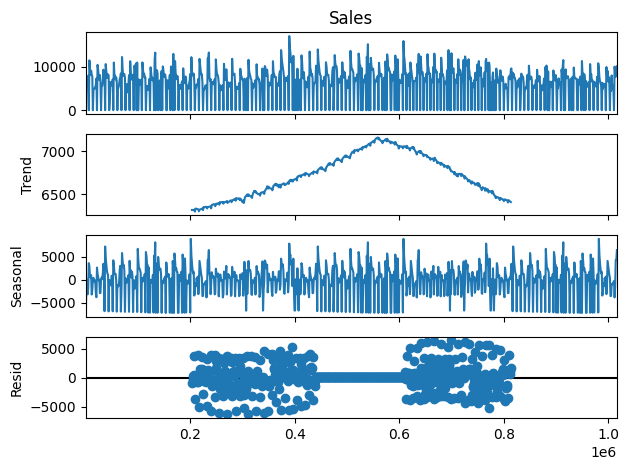

In [16]:
seasonal_decompose(df_store_x['Sales'], period=365).plot()

#### Verify stationarity assumtion 

In [17]:
adf_res = adfuller(df_store_x['Sales'])

In [18]:
labels = ['Augmented Dickey-Fuller test','p-value','number of lags used', 'no of obs', 'critical values', 'icbest']
out = pd.Series(adf_res,index=labels)

In [19]:
out

Augmented Dickey-Fuller test                                            -4.862315
p-value                                                                  0.000041
number of lags used                                                            21
no of obs                                                                     920
critical values                 {'1%': -3.4374778690219956, '5%': -2.864686684...
icbest                                                               16796.574734
dtype: object

Since p value is less than 0.05 there is string evidence that data is stationary

### ACF PACF plots

In [20]:
acf(df_store_x['Sales'], nlags=50)

array([ 1.        , -0.05640717,  0.00334498,  0.04599894, -0.02189872,
       -0.1285885 , -0.23812849,  0.48184466, -0.24852527, -0.17217988,
       -0.02619316, -0.00576241, -0.058012  , -0.09010434,  0.69873741,
       -0.09526309, -0.02886049,  0.01066504, -0.00817778, -0.10765653,
       -0.21350794,  0.53254246, -0.22436679, -0.1118264 , -0.00992994,
        0.00828895, -0.05460151, -0.1353296 ,  0.65730458, -0.10441206,
       -0.03542967,  0.00414869, -0.00487372, -0.0863739 , -0.17839469,
        0.55257595, -0.18250545, -0.09852669,  0.00636639,  0.01015266,
       -0.07489407, -0.12102585,  0.59380382, -0.14320865, -0.0599614 ,
       -0.00159797,  0.0132978 , -0.0886084 , -0.1797799 ,  0.58667622,
       -0.19708949])

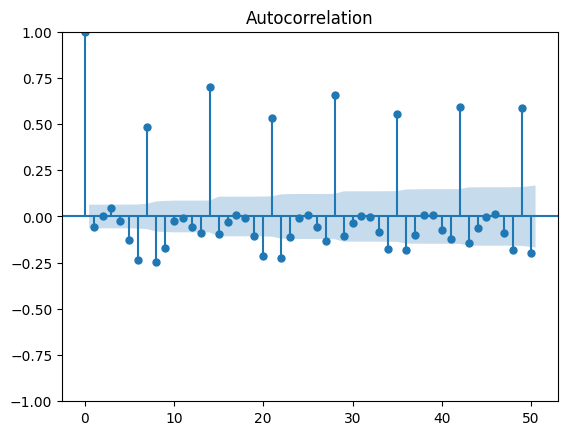

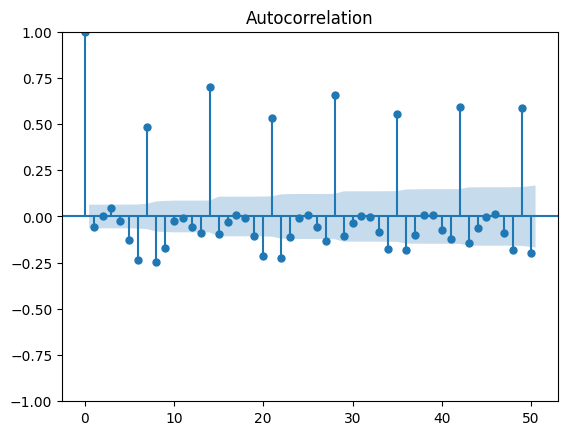

In [21]:
# plot_acf(df2,title=title,lags=lags);
plot_acf(df_store_x['Sales'], lags=50)

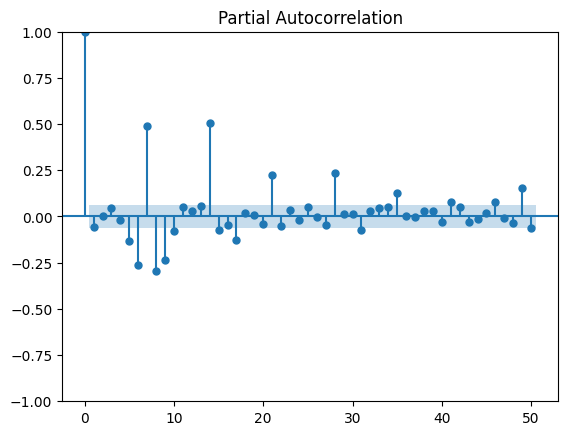

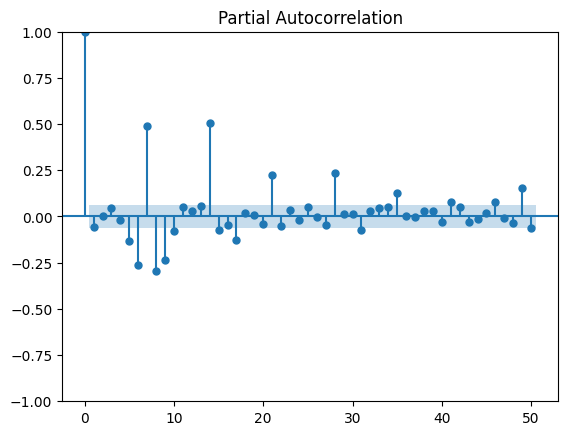

In [22]:
plot_pacf(df_store_x['Sales'], lags=50)

ACF plot reflects a 7 day seasonality 

#### Train test split 

In [23]:
store_train_df = df_store_x[:-50]
store_test_df = df_store_x[-50:]

## SARIMA model

In [24]:
search_res = auto_arima(df_store_x['Sales'], start_p=0, start_q=0, max_p=3, max_q=8, seasonal=True, 
                        m=7, max_P=8, max_D=4, max_Q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=18062.020, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17991.450, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17957.563, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=19461.490, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=18061.274, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=17952.404, Time=0.33 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=18020.764, Time=0.11 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=17643.569, Time=1.04 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=17953.702, Time=0.53 sec
 ARIMA(0,0,1)(3,0,1)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=17637.897, Time=2.66 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=17758.400, Time=1.09 sec
 ARIMA(0,0,1)(3,0,2)[7] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   :

In [25]:
search_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                SARIMAX Results                                                 
================================================================================================================
Dep. Variable:                                                        y   No. Observations:                  942
Model:             SARIMAX(0, 0, 3)x(0, 0, [1, 2, 3, 4, 5, 6, 7, 8], 7)   Log Likelihood               -8653.117
Date:                                                  Sat, 01 Jun 2024   AIC                          17332.235
Time:                                                          23:12:27   BIC                          17395.259
Sample:                                                               0   HQIC                         17356.258
                                                                  - 942                                         
Covariance Type:                                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6483.2172    346.935     18.687      0.000    5803.236    7163.198
ma.L1          0.1193      0.024      4.952      0.000       0.072       0.167
ma.L2          0.1521      0.033      4.606      0.000       0.087       0.217
ma.L3          0.1474      0.026      5.708      0.000       0.097       0.198
ma.S.L7        0.1140      0.030      3.776      0.000       0.055       0.173
ma.S.L14       0.4530      0.027     16.677      0.000       0.400       0.506
ma.S.L21       0.2192      0.032      6.927      0.000       0.157       0.281
ma.S.L28       0.4419      0.030     14.691      0.000       0.383       0.501
ma.S.L35       0.2061      0.033      6.184      0.000       0.141       0.271
ma.S.L42       0.2753      0.032      8.543      0.000       0.212       0.338
ma.S.L49       0.2405      0.030      7.949      0.000       0.181       0.300
ma.S.L56       0.1726      0.035      4.911      0.000       0.104       0.241
sigma2      5.518e+06   1.98e+05     27.902      0.000    5.13e+06    5.91e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               188.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.45
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sarima = SARIMAX(store_train_df['Sales'], order=(0, 0, 3), seasonal_order=(0, 0, 8, 7))
sarima_model = sarima.fit()
sarima_model.summary()

In [ ]:
start = len(store_train_df)
end = start + len(store_test_df) - 1
sarima_forecast = sarima_model.predict(start=start, end=end)

In [ ]:
forecast_df = store_test_df[['Store', 'Date', 'Sales']].copy()
forecast_df['SarimaForecast'] = np.array(sarima_forecast)
forecast_df.head()

## SARIMAX model (with exogenous)

In [28]:
df_store_x.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c'],
      dtype='object')

In [29]:
exog_cols = ['DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday__0', 'StateHoliday__a',
       'StateHoliday__b', 'StateHoliday__c']
exog = df_store_x[exog_cols].to_numpy()
print(exog.shape)
exog


(942, 9)


array([[   2,    0,    0, ...,    1,    0,    0],
       [   3,  900,    1, ...,    0,    0,    0],
       [   4,  802,    1, ...,    0,    0,    0],
       ...,
       [   3,  732,    1, ...,    0,    0,    0],
       [   4,  877,    1, ...,    0,    0,    0],
       [   5, 1021,    1, ...,    0,    0,    0]])

In [30]:
search_res = auto_arima(df_store_x['Sales'], exog, start_p=0, start_q=0, max_p=3, max_q=8, seasonal=True, 
                        m=7, max_P=8, max_D=4, max_Q=8, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14726.973, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=14508.460, Time=1.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=14342.843, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14724.974, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=14310.804, Time=0.79 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=14343.131, Time=1.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=14311.129, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=14315.095, Time=0.76 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=14506.747, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=14314.682, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=14309.438, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=14310.822, Time=1.09 sec
 ARIMA(0,1,1)(0,0,1)[7]        

In [32]:
search_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  942
Model:             SARIMAX(1, 1, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -7088.081
Date:                                Sat, 01 Jun 2024   AIC                          14218.161
Time:                                        21:53:35   BIC                          14319.947
Sample:                                             0   HQIC                         14256.961
                                                - 942                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -95.0637     43.296     -2.196      0.028    -179.922     -10.205
x2             9.5532      0.122     78.039      0.000       9.313       9.793
x3         -1975.3456    371.026     -5.324      0.000   -2702.544   -1248.147
x4          1222.0734     66.745     18.310      0.000    1091.256    1352.891
x5            81.8760     55.847      1.466      0.143     -27.583     191.335
x6           496.0034   4988.166      0.099      0.921   -9280.623    1.03e+04
x7          -335.8065   4970.355     -0.068      0.946   -1.01e+04    9405.911
x8            38.9406   4962.916      0.008      0.994   -9688.196    9766.077
x9          -199.1429   4974.826     -0.040      0.968   -9949.622    9551.336
ar.L1         -0.8434      0.156     -5.411      0.000      -1.149      -0.538
ma.L1          0.1361      0.158      0.862      0.389      -0.173       0.446
ma.L2         -0.7142      0.115     -6.194      0.000      -0.940      -0.488
ma.L3         -0.1605      0.048     -3.369      0.001      -0.254      -0.067
ma.L4         -0.1427      0.041     -3.522      0.000      -0.222      -0.063
ma.L5         -0.0154      0.049     -0.318      0.750      -0.110       0.080
ar.S.L7        0.3989      0.166      2.399      0.016       0.073       0.725
ar.S.L14       0.6774      0.112      6.070      0.000       0.459       0.896
ar.S.L21      -0.1042      0.060     -1.724      0.085      -0.223       0.014
ma.S.L7       -0.4384      0.163     -2.693      0.007      -0.757      -0.119
ma.S.L14      -0.4540      0.134     -3.384      0.001      -0.717      -0.191
sigma2      2.274e+05   9528.884     23.863      0.000    2.09e+05    2.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               290.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
store_train_df = df_store_x[:-50]
store_test_df = df_store_x[-50:]

In [35]:
model = SARIMAX(store_train_df['Sales'], exog=store_train_df[exog_cols], order=(1, 1, 5), seasonal_order=(3, 0, 0, 2))
results = model.fit()
results.summary()

/home/harsh242/mambaforge/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/harsh242/mambaforge/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55673D+00    |proj g|=  5.65071D-02

At iterate    5    f=  7.55355D+00    |proj g|=  3.75152D-03

At iterate   10    f=  7.55097D+00    |proj g|=  3.39163D-02

At iterate   15    f=  7.54903D+00    |proj g|=  3.89916D-03

At iterate   20    f=  7.54854D+00    |proj g|=  1.15554D-03

At iterate   25    f=  7.54850D+00    |proj g|=  2.91093D-03

At iterate   30    f=  7.54831D+00    |proj g|=  1.41304D-03

At iterate   35    f=  7.54828D+00    |proj g|=  1.48839D-03

At iterate   40    f=  7.54827D+00    |proj g|=  2.25461D-04

At iterate   45    f=  7.54824D+00    |proj g|=  3.10702D-03

At iterate   50    f=  7.54749D+00    |proj g|=  1.30179D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/harsh242/mambaforge/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  892
Model:             SARIMAX(1, 1, 5)x(3, 0, [], 2)   Log Likelihood               -6732.358
Date:                            Sat, 01 Jun 2024   AIC                          13502.717
Time:                                    21:58:06   BIC                          13593.771
Sample:                                         0   HQIC                         13537.517
                                            - 892                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DayOfWeek         -88.4650     12.737     -6.945      0.000    -113.430     -63.500
Customers           9.6282      0.107     90.061      0.000       9.419       9.838
Open            -2063.4120    134.971    -15.288      0.000   -2327.950   -1798.874
Promo            1218.7718     61.496     19.819      0.000    1098.241    1339.302
SchoolHoliday      25.8510     52.562      0.492      0.623     -77.169     128.871
StateHoliday__0   512.6235   6813.872      0.075      0.940   -1.28e+04    1.39e+04
StateHoliday__a  -354.0714   6815.376     -0.052      0.959   -1.37e+04     1.3e+04
StateHoliday__b    62.7425   6807.680      0.009      0.993   -1.33e+04    1.34e+04
StateHoliday__c  -221.3007   6817.753     -0.032      0.974   -1.36e+04    1.31e+04
ar.L1              -0.9239      0.105     -8.832      0.000      -1.129      -0.719
ma.L1               0.2314      0.112      2.061      0.039       0.011       0.452
ma.L2              -1.4200      0.237     -5.996      0.000      -1.884      -0.956
ma.L3              -0.3457      0.104     -3.335      0.001      -0.549      -0.142
ma.L4               0.4879      0.222      2.195      0.028       0.052       0.924
ma.L5               0.1121      0.065      1.718      0.086      -0.016       0.240
ar.S.L2             0.6432      0.258      2.495      0.013       0.138       1.148
ar.S.L4            -0.1388      0.063     -2.215      0.027      -0.262      -0.016
ar.S.L6            -0.0877      0.050     -1.740      0.082      -0.186       0.011
sigma2           2.212e+05   9407.920     23.510      0.000    2.03e+05     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               266.85
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
start = len(store_train_df)
end = start + len(store_test_df) - 1
forecast = results.predict(start=start, end=end, exog=store_test_df[exog_cols])

/home/harsh242/mambaforge/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/harsh242/mambaforge/envs/notebook/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [192]:
store_test_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday__0,StateHoliday__a,StateHoliday__b,StateHoliday__c
961563,1011,5,2015-06-12,6048,708,1,0,0,1,0,0,0
962678,1011,6,2015-06-13,6531,853,1,0,0,1,0,0,0
963793,1011,7,2015-06-14,0,0,0,0,0,1,0,0,0
964908,1011,1,2015-06-15,10660,1016,1,1,0,1,0,0,0
966023,1011,2,2015-06-16,7895,854,1,1,0,1,0,0,0


In [204]:
forecast_df = store_test_df[['Store', 'Date', 'Sales']].copy()
forecast_df['Forecast'] = np.array(forecast)
forecast_df.head()

,Store,Date,Sales,Forecast
961563,1011,2015-06-12,6048,5241.928458
962678,1011,2015-06-13,6531,6566.749963
963793,1011,2015-06-14,0,287.330879
964908,1011,2015-06-15,10660,9750.550440
966023,1011,2015-06-16,7895,8110.912645


In [205]:
forecast_df.tail()

,Store,Date,Sales,Forecast
1011738,1011,2015-07-27,10066,8681.546095
1012853,1011,2015-07-28,8673,7936.334936
1013968,1011,2015-07-29,7755,6867.661284
1015083,1011,2015-07-30,9227,8173.562015
1016198,1011,2015-07-31,10134,9473.161573


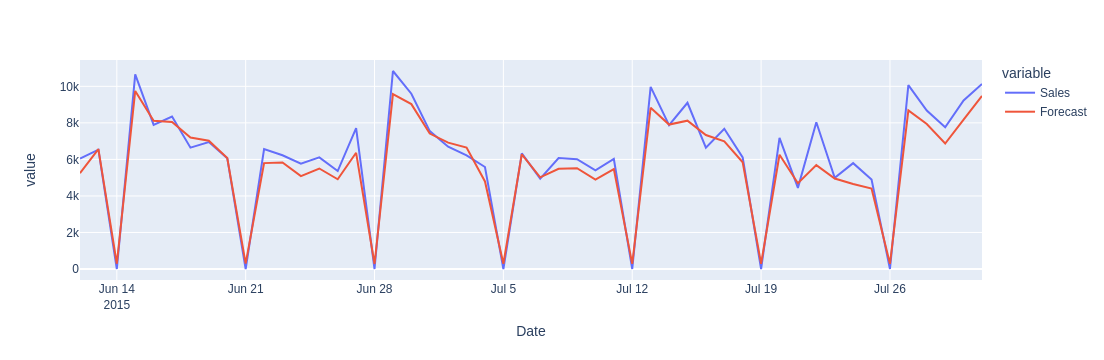

In [207]:
fig = px.line(forecast_df, x="Date", y=["Sales", "Forecast"])
fig.show()

In [209]:
rmse = np.sqrt(mean_squared_error(forecast_df['Sales'], forecast_df['Forecast']))
rmse

723.1067071032126

In [213]:
df_store_x.isnull().sum()

Store              0
DayOfWeek          0
Date               0
Sales              0
Customers          0
Open               0
Promo              0
SchoolHoliday      0
StateHoliday__0    0
StateHoliday__a    0
StateHoliday__b    0
StateHoliday__c    0
dtype: int64